In [13]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import json
import psutil
import time
import os

app_path = "../bin/daphne"
#args = "../test.daph"
args = "./kmeans.daphne r=10000 c=10 f=500 i=100"
args = os.path.abspath(args)
update_in_place = False

In [14]:
def run_command(update_in_place, args):
    #command = "echo $$ && ../bin/daphne " + ("--update-in-place" if update_in_place else "") + " --timing " + args
    #command = ["../bin/daphne", (" --update-in-place" if update_in_place else ""), " --timing ", args]

    #split args into list
    args = args.split(" ")

    if update_in_place:
        command = ["../bin/daphne", "--update-in-place", "--timing"] + args
    else:
        command = ["../bin/daphne", "--timing"] + args

    print("Running command: " + str(command))    

    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
   
    process_memory = psutil.Process(process.pid)
    current_pid = os.getpid()
    print("Current PID:", current_pid)

    # Print the process details
    print(f"Subprocess PID: {process.pid}")
    print(f"Subprocess name: {process_memory.name()}")
    print(f"Subprocess status: {process_memory.status()}")

    peak_mem = 0

    while process.poll() is None:  # Check if the process has finished
        mem_info = process_memory.memory_info().rss // 1024  # Memory usage in KB
        if mem_info > peak_mem:
            peak_mem = mem_info

        time.sleep(0.001)

    print(f"Peak memory usage: {peak_mem} KB")

    _, stderr = process.communicate()
    return command, peak_mem, stderr.decode().splitlines()[-1]

def run_benchmarks(update_in_place, args, n):
    results = []
    for i in range(n):
        print("\033[91m")
        print("Running benchmark " + str(i) + "...")
        print("\033[0m")
        results.append(run_command(update_in_place, args))
    print(results)
    return results


Running benchmark 0...

Running command: ['../bin/daphne', '--update-in-place', '--timing', '/home/niklas/daphne/bench/kmeans.daphne', 'r=10000', 'c=10', 'f=500', 'i=100']
Current PID: 1388269
Subprocess PID: 1418982
Subprocess name: daphne
Subprocess status: running
Peak memory usage: 162572 KB

Running benchmark 1...

Running command: ['../bin/daphne', '--update-in-place', '--timing', '/home/niklas/daphne/bench/kmeans.daphne', 'r=10000', 'c=10', 'f=500', 'i=100']
Current PID: 1388269
Subprocess PID: 1419031
Subprocess name: daphne
Subprocess status: running
Peak memory usage: 163712 KB

Running benchmark 2...

Running command: ['../bin/daphne', '--update-in-place', '--timing', '/home/niklas/daphne/bench/kmeans.daphne', 'r=10000', 'c=10', 'f=500', 'i=100']
Current PID: 1388269
Subprocess PID: 1419066
Subprocess name: daphne
Subprocess status: running
Peak memory usage: 163528 KB

Running benchmark 3...

Running command: ['../bin/daphne', '--update-in-place', '--timing', '/home/niklas

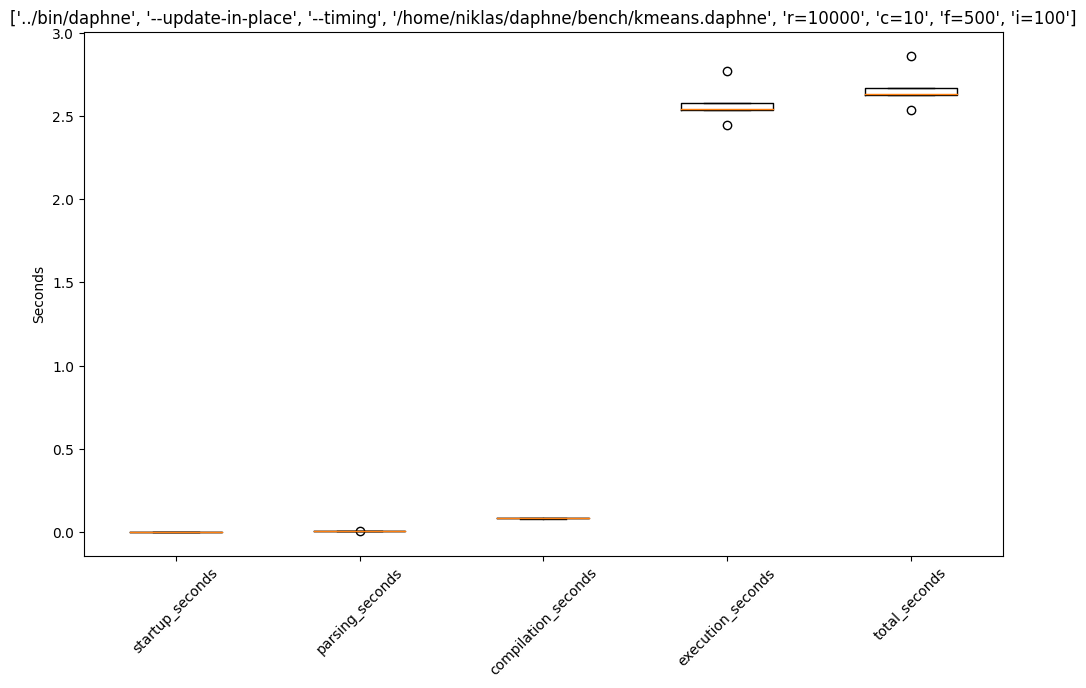

Average peak memory: 163063.2 KB


In [15]:
n_benchmarks = 5
_results = run_benchmarks(update_in_place=False, args=args, n=n_benchmarks)

title = _results[0][0]
peak_mem = [result[1] for result in _results]

results = [json.loads(json_str[2]) for json_str in _results]

values_list = [[data[value_name] for data in results] for value_name in results[0].keys()]
plt.figure(figsize=(10, 6))

plt.boxplot(values_list, labels=results[0].keys())
plt.title(title)
plt.ylabel('Seconds')

# Adjust layout
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

print("Average peak memory:", np.mean(peak_mem), "KB")


In [47]:
import time

pid = 2815730

while True:
    mem_info = psutil.Process(pid).memory_info()
    mem_usage = mem_info.rss / 1024 / 1024

    print(f"Memory usage: {mem_usage:.2f} MB")

    time.sleep(0.1)

Memory usage: 1450.86 MB
Memory usage: 1460.65 MB
Memory usage: 1470.45 MB
Memory usage: 1480.50 MB
Memory usage: 1490.82 MB
Memory usage: 1500.61 MB
Memory usage: 1509.64 MB
Memory usage: 1519.69 MB
Memory usage: 1530.52 MB
Memory usage: 1537.74 MB
Memory usage: 1546.76 MB
Memory usage: 1557.07 MB
Memory usage: 1567.90 MB
Memory usage: 1578.47 MB
Memory usage: 1588.53 MB
Memory usage: 1599.10 MB
Memory usage: 1609.41 MB
Memory usage: 1619.46 MB
Memory usage: 1629.78 MB
Memory usage: 1640.09 MB
Memory usage: 1648.86 MB
Memory usage: 1659.17 MB
Memory usage: 1670.00 MB
Memory usage: 1681.34 MB
Memory usage: 1691.91 MB
Memory usage: 1702.22 MB
Memory usage: 1710.47 MB
Memory usage: 1720.01 MB
Memory usage: 1728.26 MB
Memory usage: 1737.03 MB
Memory usage: 1746.31 MB
Memory usage: 1756.62 MB
Memory usage: 1765.64 MB
Memory usage: 1775.96 MB
Memory usage: 1786.53 MB
Memory usage: 1795.55 MB
Memory usage: 1802.51 MB
Memory usage: 1809.21 MB
Memory usage: 1815.92 MB
Memory usage: 1825.46 MB


NoSuchProcess: process PID not found (pid=2815730)